In [1]:
from NOAAStations import TidalStation
from DeviceModels import Turbine, calculate_power
from Calculator import maintenance, operation

from ipywidgets import widgets, interact, fixed
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
import scipy
import scipy.interpolate
from contextlib import redirect_stdout
figsize(12, 10)
sbn.set_context("paper", font_scale=1)
sbn.set_style("whitegrid")


from collections import namedtuple


### Testing for the maintenance monte carlo simulation

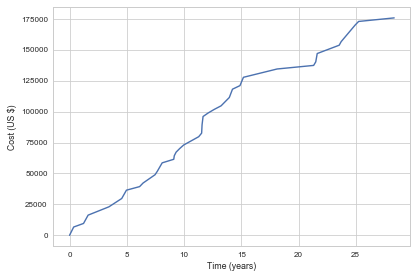

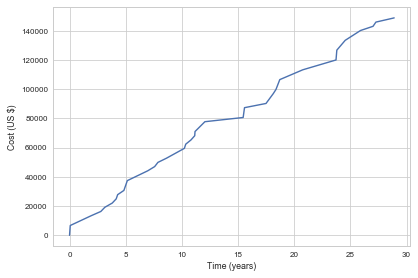

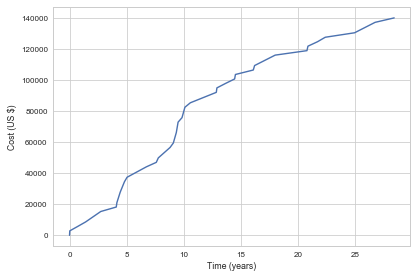

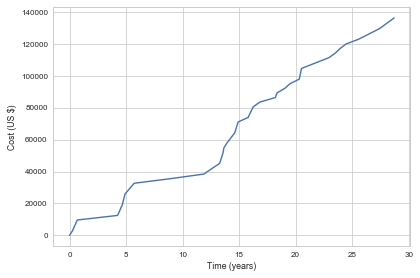

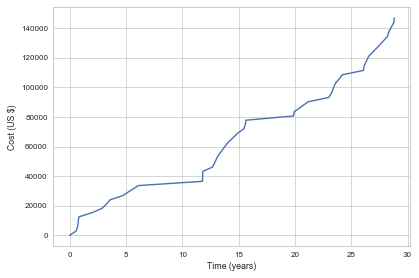

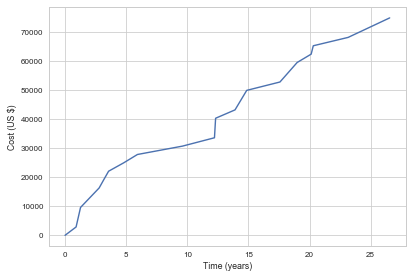

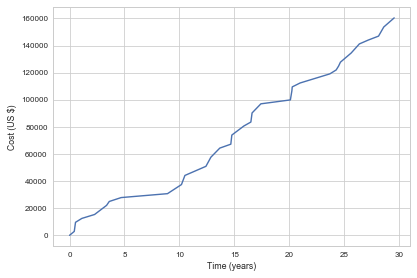

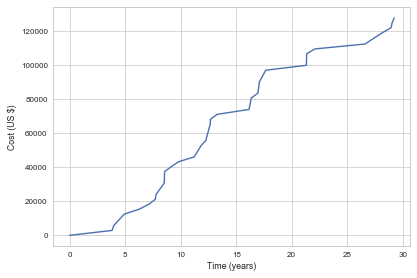

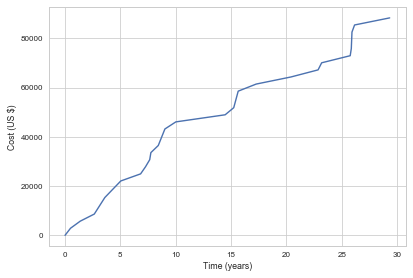

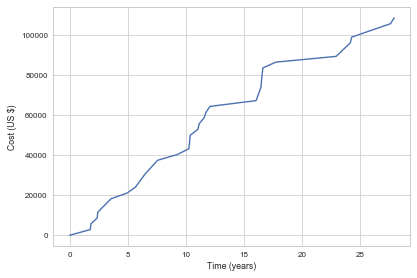

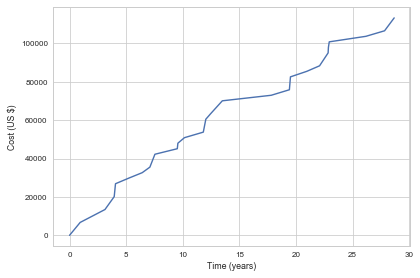

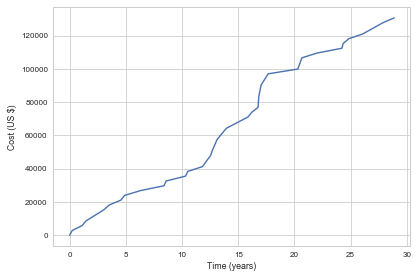

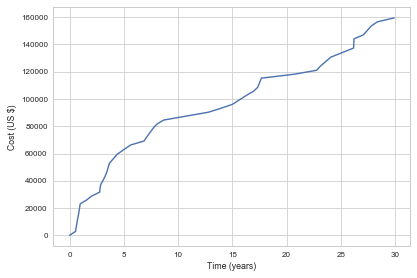

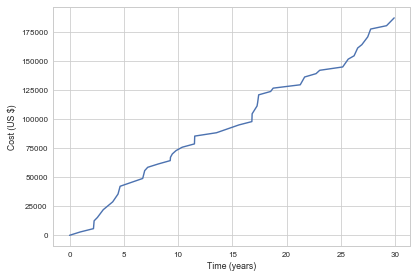

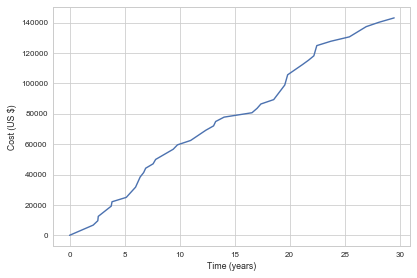

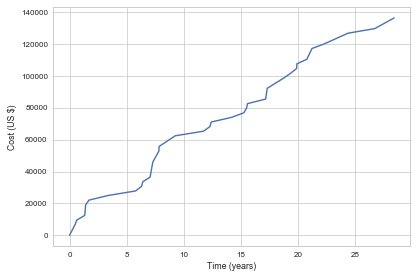

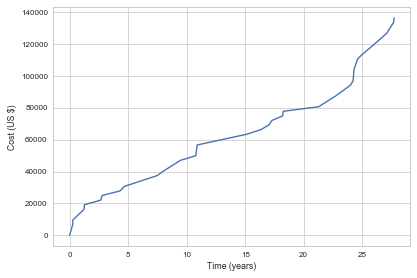

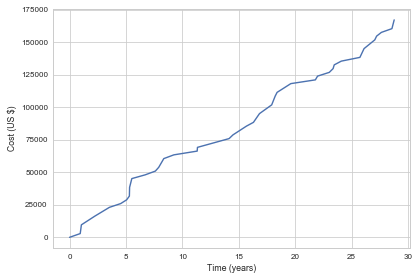

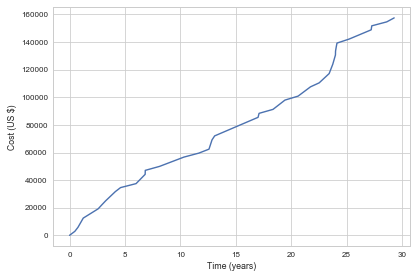

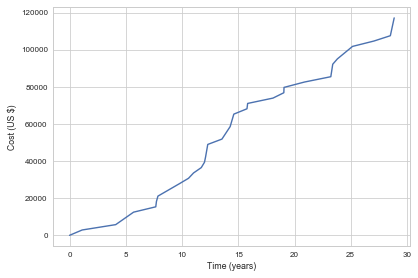

In [2]:
Maintenance_Rate = namedtuple('Parameter', 'partname minimal_rate midlevel_rate severe_rate minimal_cost midlevel_cost severe_cost number labor')

emergency_maintenance = [
    Maintenance_Rate('Blade', 0.042, 0.0273, 0.00007, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Others', 0.03, 0.0299, 0.00006, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Gear Box',0.2125, 0.0325, 0.0005, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Electricity Generator', 0.065, 0.0545, 0.0065, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Shaft', 0.002, 0.007, .001, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Brake', 0.0153, 0.0325, 0.0025, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Cable', 0.225, 0.09247, 0.000002, 1., 4., 10., 1., 40.),
    Maintenance_Rate('Control system', 0.1, 0.1, 0.0001, 1., 4., 10., 1., 40.)
]

emergency_events = [maintenance.EmergencyMaintenance(
            e.minimal_rate, 
            e.midlevel_rate, 
            e.severe_rate,
            e.minimal_cost, 
            e.midlevel_cost, 
            e.severe_cost,
            e.number, 
            e.labor, 
            e.partname)
            for e in emergency_maintenance]

lifetime = 30.

result_list = []
for i in range(20):
    result_list.append(maintenance.lifetimeMonteCarlo(lifetime, emergency_events, graph = True))


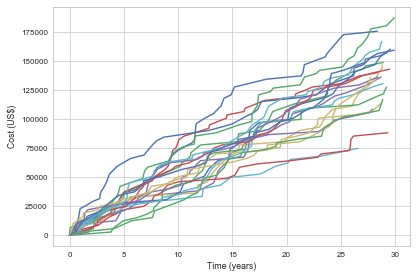

In [3]:
for result in result_list:
    time, cost = result
    plt.plot(time, cost)
plt.xlabel('Time (years)')
plt.ylabel('Cost (US$)')
plt.savefig('MonteCarlo.png', format='png', transparent=True, bbox_inches='tight')

### Harmonic Constituents 

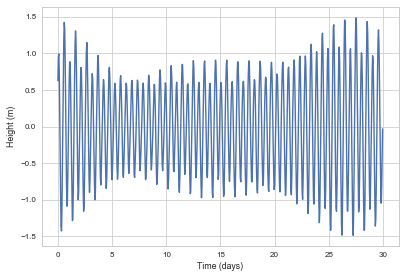

In [4]:
import plotly.plotly as py
import plotly.graph_objs as go

test_station = TidalStation(8447191)
time, height = test_station.predictWaterLevels(0, 24*30)

plt.plot(time/24, height)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.savefig('HarmonicConstituents.png', format='png', transparent=True, bbox_inches='tight')
# trace = go.Scatter(
#     x = time/24,
#     y = height,
#     mode = 'lines',
#     name = 'lines',
#     line = dict(color = 'rgb(52, 165, 218)')
# )

# layout = go.Layout(
#     title = 'Water Level Height | Bournedale, Cape Cod Canal',
#     titlefont = dict(
#         size = 26,
#         color = 'rgb(131, 135, 135)'),
#     xaxis = dict(title = 'Time (Days)',
#         titlefont = dict(
#         size = 20,
#         color = 'rgb(131, 135, 135)'),
#         tickfont=dict(
#             size=16,
#             color='rgb(131, 135, 135)'
#         )),
#     yaxis = dict(title = 'Height from MLLW (Meters)',
#         titlefont = dict(
#         size = 20,
#         color = 'rgb(131, 135, 135)'),
#         tickfont=dict(
#             size=16,
#             color='rgb(131, 135, 135)'
#         )),
#     paper_bgcolor='transparent',
#     plot_bgcolor='transparent')

# fig = go.Figure(data = [trace], layout=layout)
# py.iplot(fig, filename='harmonicConstituent')

### Testing for the power output generation

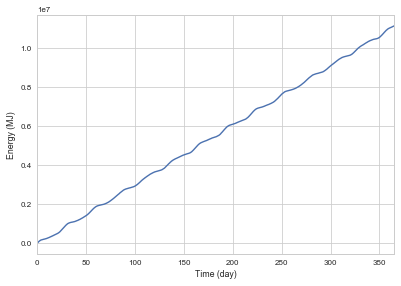

In [5]:
MCT = Turbine(1200., 0.1835, 3.55361367,  2.30706792,  1.05659521)
Sagamore = TidalStation(8447173)
results, times = calculate_power(Sagamore, MCT, 0, 0, 365*24*3600, 9.8, 3)

plt.plot(times/(24*3600), results/1000)
plt.xlim(0,365)
plt.ylabel('Energy (MJ)')
plt.xlabel('Time (day)')
plt.savefig('PowerOutput.png', format='png', transparent=True, bbox_inches='tight')

### Build power curve model

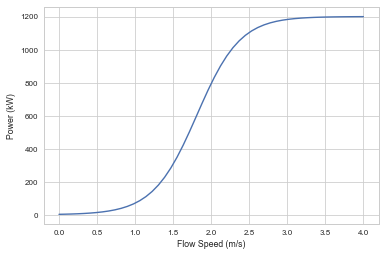

In [6]:
def richardsCurve(Velocity,B,M,g):
    return 1200*(1+.1835*np.exp(-1*B*(Velocity-M)))**(-1/g)

import scipy.optimize
import numpy as np

velocities = np.array([0,.5,1,1.5,2,2.5,3,3.5,4,10])
power = np.array([0,20,75,300,800, 1100, 1175, 1195, 1200,1200])

starting_guess = (1, 1, 1)

optimized_parameters, covariance = scipy.optimize.curve_fit(richardsCurve, 
                                                                 xdata = velocities, 
                                                                 ydata = power, 
                                                                 p0 = starting_guess)
x = np.linspace(0,4)
y = richardsCurve(x, *optimized_parameters)

%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(x,y)
plt.ylabel('Power (kW)')
plt.xlabel('Flow Speed (m/s)')
plt.savefig('RichardsCurve.png', format='png', transparent=True, bbox_inches='tight')

In [ ]:
def LevelizedCostofElectricity(station_id, 
                               grid_location,
                               cap_ex,
                               lifetime, 
                               K, Q, B, M, g,
                               h_0,
                               gravity,
                               emergency_maintentance):
    
    '''
    This function will calculated the levelized cost of electricity given the parameters for maintenance, power generation, installation
    and lifetime
    station_id will determine the location due to the necessity to use harmonic constituents for the calculations
    grid_location is where the connections will be made
    cap_ex are the capital expenditures for the cost of the turbine and fixtures
    this function was written with a sensitivity analysis in mind
    '''
    
    MCT = Turbine(K, Q, B, M, g)
    
    tidal_station = TidalStation(station_id)
    
    emergency_events = [maintenance.EmergencyMaintenance(
                e['minimal_rate'], 
                e['midlevel_rate'], 
                e['severe_rate'],
                e['minimal_cost'], 
                e['midlevel_cost'], 
                e['severe_cost'],
                e['minimal_downtime'], 
                e['midlevel_downtime'], 
                e['severe_downtime'],
                e['number'], 
                e['labor'], 
                e['partname'])
                for e in emergency_maintentance]

    #installation_cost = installation.calculateInstallation() 
        
        
    ###
    # The following code is used to run the monte carlo simulation with feedback to the power generation functions
    # where the downtime requires the turbine to no longer generate an output
    ###
    time = []
    results = []
    end_loop = False
    time_tracker = 0.
    
    maintenance_costs = []
    maintenance_times = []
    
    #time to run the simulation
    while not end_loop:
        
        maintenance_event, uptime = monteCarlo(emergency_events)
        
        if time_tracker + uptime > lifetime:
            end_loop = True
            uptime = lifetime - time_tracker
        
        
        end_time = timetracker + uptime
        results_array , time_array = calculate_power(tidal_station, 
                                                     MCT, 
                                                     results[-1][-1], 
                                                     time_tracker, 
                                                     end_time, 
                                                     gravity, 
                                                     h_0)
        
        maintenance_costs.append(maintenance_event.event_cost)
        maintenance_times.append(time_tracker+uptime)
        time_tracker += uptime + maintenance_event.downtime
        results.append(results_array)
        time.append(time_array)
        
    powerGen = np.concatenate(results)
    times = np.concatenate(time)
    
    
    # Process the final costs and return the levelized cost
    total_cost = maintenance_costs[-1] + installation_cost
    total_power = powerGen[-1]
    return total_cost/total_power

In [7]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

from SALib.sample.saltelli import sample as ss
from SALib.analyze.sobol import analyze as sa

ModuleNotFoundError: No module named 'SALib'

In [ ]:
Parameter = namedtuple('Parameter', 'name nominal min max description units')
Fixed = namedtuple('Parameter', 'name value description units')
Maintenance = namedtuple('Parameter', 'name nominal min max description units')

parameters_list = [
Parameter('K', 1200.),
Parameter('Q', 0.184),
Parameter('B', 3.554),
Parameter('M', 2.307),
Parameter('g', 1.057),
Fixed('gravity' ,9.8, 'Earth is heavy', '$\frac{m}{s^2}$'),

Maintenance('minimal_rate', 500, 400, 510, 'blade','year^-1'),
Maintenance('midlevel_rate', 3.5, 3, 3.6, 'blade', 'year^-1'),
Maintenance('severe_rate', 3.5, 3, 3.6, 'blade', 'year^-1'),
    ]

parameters_dict = {i.name: i for i in parameters_list}

fixed_parameter_values = {i.name: i.value for i in parameters_list if isinstance(i,Fixed)}

salib_problem = {}
variables = [i for i in parameters_list if isinstance(i,Parameter)]
salib_problem['num_vars']=len(variables)
salib_problem['names'] = [i.name for i in variables]
salib_problem['bounds'] = [[i.min, i.max] for i in variables]
salib_problem['groups'] = None
salib_problem


